In [1]:
import pandas as pd
import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import newton, brentq
from scipy.stats import norm

In [2]:
options = pd.read_csv("data/options.csv")

In [3]:
options.head()

,date_current,ticker,expiration_date,days_to_expiry,option_id,option_type,strike_price,bid_price,option_price,ask_price,implied_volatility,volume,open_interest,stock_price,dividend_yield,tdays_to_expiry,rate,bivs,nivs
0,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C235,C,235.0,72.31,72.51,72.44,180.66,0,1,307.07,1.81,2,0.0292,1.533355,0.00000
1,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C245,C,245.0,62.30,45.79,62.43,155.37,0,0,307.07,1.81,2,0.0292,1.319855,0.00000
2,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C250,C,250.0,57.30,49.31,57.44,143.75,1,1,307.07,1.81,2,0.0292,1.221679,0.00000
3,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C260,C,260.0,47.31,47.62,47.44,120.51,0,10,307.07,1.81,2,0.0292,1.024587,0.00000
4,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C265,C,265.0,42.31,33.93,42.44,108.79,0,0,307.07,1.81,2,0.0292,0.925710,0.92571


In [4]:
options[options.nivs == 0].shape

(103070, 19)

In [5]:
options[options.bivs == 0].shape

(92363, 19)

In [6]:
options[(options.nivs == 0) & (options.bivs != 0)].shape

(10712, 19)

In [7]:
options[(options.bivs == 0) & (options.nivs != 0)].shape

(5, 19)

In [8]:
options.head()

,date_current,ticker,expiration_date,days_to_expiry,option_id,option_type,strike_price,bid_price,option_price,ask_price,implied_volatility,volume,open_interest,stock_price,dividend_yield,tdays_to_expiry,rate,bivs,nivs
0,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C235,C,235.0,72.31,72.51,72.44,180.66,0,1,307.07,1.81,2,0.0292,1.533355,0.00000
1,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C245,C,245.0,62.30,45.79,62.43,155.37,0,0,307.07,1.81,2,0.0292,1.319855,0.00000
2,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C250,C,250.0,57.30,49.31,57.44,143.75,1,1,307.07,1.81,2,0.0292,1.221679,0.00000
3,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C260,C,260.0,47.31,47.62,47.44,120.51,0,10,307.07,1.81,2,0.0292,1.024587,0.00000
4,2019-11-06,SPY,2019-11-08,2,SPY 2019-11-08 C265,C,265.0,42.31,33.93,42.44,108.79,0,0,307.07,1.81,2,0.0292,0.925710,0.92571


In [15]:
Ss = options.stock_price.values
Ks = options.strike_price.values
rs = options.rate.values / 100
Ts = options.tdays_to_expiry.values / 252
qs = options.dividend_yield.values / 100
ts = options.option_type.map({"C" : 1, "P" : -1}).values
Ms = (options.ask_price + options.bid_price).values * 0.5
Vs = options.bivs.values / 100

def bs_price(r, S, K, T, v, q, t, M):
    
    d1 = np.log(S / K) + (r + 0.5 * v * v) * T
    d1 /= np.sqrt(T) * v
    d2 = d1 - np.sqrt(T) * v
    
    if t == 1:
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def root(r, *args):
    return bs_price(r, *args) - M

In [20]:
brent_rs = []
for i, (S, K, T, v, q, t, M) in enumerate(zip(Ss, Ks, Ts, Vs, qs, ts, Ms)):

    if i % 100000 == 0:
        print(i / len(Ss) * 100)

    try:
        iv = brentq(root, 0, 0.2, args=(S, K, T, v, q, t, M), maxiter=10_000)
    except Exception as e:
        iv = 0
    brent_rs.append(iv)

0.0


/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


6.288489485960004
12.576978971920008


KeyboardInterrupt: 

In [21]:
len(brent_rs)

213551

In [22]:
tmp = options.iloc[:len(brent_rs)].reset_index(drop=True)[['rate']]
tmp['rate'] = tmp.rate.values / 100
tmp['brs'] = brent_rs

In [23]:
tmp[['rate', 'brs']].head(100).tail(50)

,rate,brs
50,0.000292,0.000000
51,0.000292,0.000000
52,0.000292,0.000000
53,0.000292,0.000000
54,0.000292,0.000000
55,0.000292,0.000000
56,0.000292,0.000000
57,0.000292,0.000000
58,0.000292,0.000000
59,0.000292,0.000000


In [14]:
(tmp.brs - tmp.rate).describe()

count    310924.000000
mean          0.015912
std           0.136401
min          -0.018082
25%          -0.000760
50%           0.002196
75%           0.005479
max           8.696750
dtype: float64

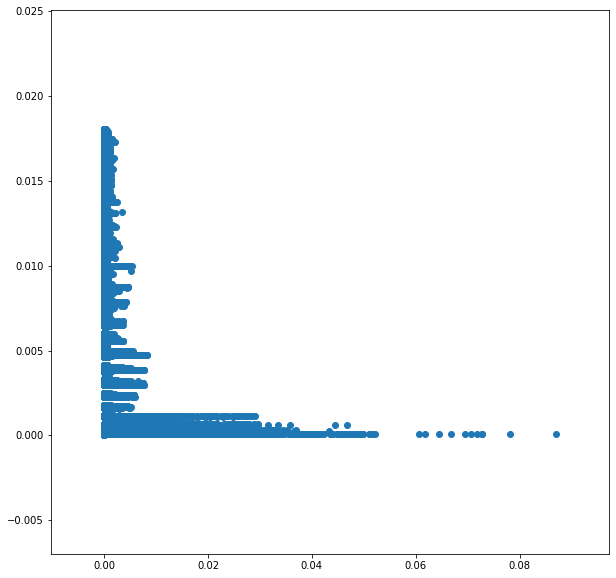

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(tmp.brs / 100, tmp.rate)
plt.show()